# Member Classification Model

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
from torch_geometric.data import DataLoader, Dataset, Data
import lightning.pytorch as pl
import seaborn as sns
import pandas as pd
import os
from tqdm import tqdm
import torch
import itertools
import yaml
from pytorch_lightning.loggers import WandbLogger

import matplotlib.pyplot as plt
from torch_geometric.utils import to_scipy_sparse_matrix
import scipy.sparse as sps
import xxhash
from torch_cluster import knn

from epic_clustering.utils import plot_clusters, get_cluster_pos
from epic_clustering.models import MemberGNN
from epic_clustering.scoring import weighted_v_score

## 1. Training Loop

In [2]:
with open("member_gnn.yaml") as f:
    member_gnn_config = yaml.safe_load(f)
model = MemberGNN(member_gnn_config)
model.setup(stage="fit")

Converting to PyG data objects


  0%|          | 0/3010 [00:00<?, ?it/s]/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 3010/3010 [00:05<00:00, 561.17it/s]

Loaded 2000 training events, 1000 validation events and 10 testing events


In [ ]:
logger = WandbLogger(project=member_gnn_config["project"])
trainer = pl.Trainer(devices=1, accelerator="gpu", max_epochs=10, logger=logger)
trainer.fit(model)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: murnanedaniel. Use `wandb login --relogin` to force relogin


/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /global/homes/d/danieltm/.conda/envs/powerweek/lib/p ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /global/homes/d/danieltm/.conda/envs/powerweek/lib/p ...
  rank_zero_warn(
You are using a CUDA device ('NVIDIA A100-

Sanity Checking: 0it [00:00, ?it/s]

/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]torch.Size([24537, 6])
torch.Size([24537, 256])
Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.17it/s]torch.Size([19777, 6])
torch.Size([19777, 256])


/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   0%|          | 0/200 [00:00<?, ?it/s] torch.Size([23034, 6])
torch.Size([23034, 256])
Epoch 0:   0%|          | 1/200 [00:00<01:10,  2.84it/s, v_num=3btz]torch.Size([15467, 6])
torch.Size([15467, 256])
Epoch 0:   1%|          | 2/200 [00:00<00:36,  5.40it/s, v_num=3btz]torch.Size([14271, 6])
torch.Size([14271, 256])
Epoch 0:   2%|▏         | 3/200 [00:00<00:25,  7.74it/s, v_num=3btz]torch.Size([22071, 6])
torch.Size([22071, 256])
Epoch 0:   2%|▏         | 4/200 [00:00<00:19,  9.86it/s, v_num=3btz]torch.Size([23797, 6])
torch.Size([23797, 256])
Epoch 0:   2%|▎         | 5/200 [00:00<00:16, 11.77it/s, v_num=3btz]torch.Size([23995, 6])
torch.Size([23995, 256])
Epoch 0:   3%|▎         | 6/200 [00:00<00:14, 13.50it/s, v_num=3btz]torch.Size([25954, 6])
torch.Size([25954, 256])
Epoch 0:   4%|▎         | 7/200 [00:00<00:12, 15.05it/s, v_num=3btz]torch.Size([18972, 6])
torch.Size([18972, 256])
Epoch 0:   4%|▍         | 8/200 [00:00<00:11, 16.51it/s, v_num=3btz]torch.Size([19813, 6])


/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('purity', ...)` in your `validation_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(



Validation DataLoader 0:  17%|█▋        | 17/100 [00:00<00:01, 69.83it/s]torch.Size([21656, 6])
torch.Size([21656, 256])

Validation DataLoader 0:  18%|█▊        | 18/100 [00:00<00:01, 69.92it/s]torch.Size([26430, 6])
torch.Size([26430, 256])

Validation DataLoader 0:  19%|█▉        | 19/100 [00:00<00:01, 69.84it/s]torch.Size([22150, 6])
torch.Size([22150, 256])

Validation DataLoader 0:  20%|██        | 20/100 [00:00<00:01, 69.80it/s]torch.Size([22382, 6])
torch.Size([22382, 256])

Validation DataLoader 0:  21%|██        | 21/100 [00:00<00:01, 69.02it/s]torch.Size([22883, 6])
torch.Size([22883, 256])

Validation DataLoader 0:  22%|██▏       | 22/100 [00:00<00:01, 68.23it/s]torch.Size([21221, 6])
torch.Size([21221, 256])

Validation DataLoader 0:  23%|██▎       | 23/100 [00:00<00:01, 67.97it/s]torch.Size([19754, 6])
torch.Size([19754, 256])

Validation DataLoader 0:  24%|██▍       | 24/100 [00:00<00:01, 67.68it/s]torch.Size([27541, 6])
torch.Size([27541, 256])

Validation DataLoader 0

## Debug!

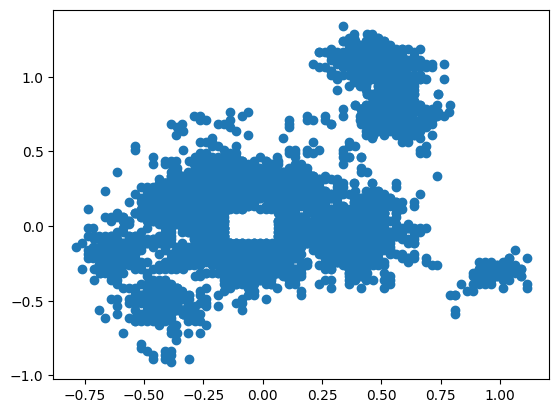

In [6]:
plt.scatter(event.x[:, 0], event.x[:, 1])

In [11]:
true_edges = event.edge_index[:, event.y.bool()]
false_edges = event.edge_index[:, ~event.y.bool()]

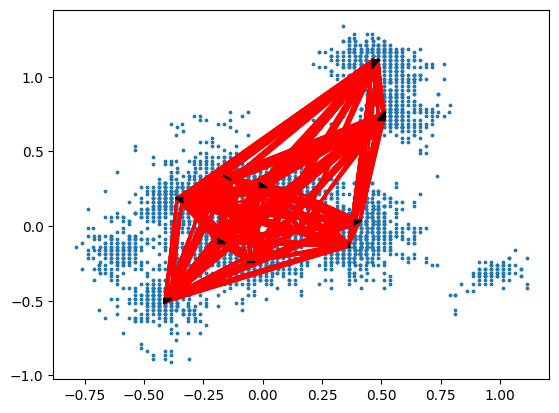

In [14]:
plt.scatter(event.x[:, 0], event.x[:, 1], s=3)
plt.plot(event.x[false_edges, 0], event.x[false_edges, 1], c="r");
plt.plot(event.x[true_edges, 0], event.x[true_edges, 1], c="k");

## 2. Inference!

In [ ]:
checkpoint_file = "/global/cfs/cdirs/m3443/data/PowerWeek/checkpoints/classifier.ckpt"

In [ ]:
model = MemberClassification.load_from_checkpoint(checkpoint_file)

In [ ]:
model.hparams["data_split"] = [5000, 100, 100]

In [ ]:
model.setup(stage="fit")

In [ ]:
input_dir = "/global/cfs/cdirs/m3443/data/PowerWeek/train/train"
num_events = sum(model.hparams["data_split"])
csv_files = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.csv')])[:num_events//1000 + 1]
events_df = pd.concat([pd.read_csv(f) for f in sorted(csv_files)])
if num_events is not None:
    events_df = events_df[events_df["event"].isin(sorted(events_df["event"].unique())[:num_events])]
events_df['clusterID'] = events_df['clusterID'].astype(np.uint64) # Needed for some reason?

In [ ]:
pd.options.mode.chained_assignment = None
def label_hits(event, events_df, pred_edges, max_dist=None):
    
    seeds_idx = pred_edges.unique()
    
    event_df = events_df[events_df.event == event.event_id]
    
    # Collect nonseeds in another tensor
    nonseeds_idx = torch.from_numpy(event_df.hit_number[~np.isin(event_df.hit_number.values, seeds_idx.long().numpy())].values).unique()

    # For each nonseed find closest seed with knn=1
    nonseeds_to_seeds = knn(torch.from_numpy(event_df[np.isin(event_df.hit_number.values, seeds_idx.long().numpy())][['posx', 'posy']].to_numpy()), torch.from_numpy(event_df[np.isin(event_df.hit_number.values, nonseeds_idx.long().numpy())][['posx', 'posy']].to_numpy()), 1)

    # Convert 0, .., N indices back to original seed_idx and nonseed_idx
    nonseeds_to_seeds = torch.stack([seeds_idx[nonseeds_to_seeds[1]], nonseeds_idx[nonseeds_to_seeds[0]]])
    
    if max_dist is not None:
        positions = torch.from_numpy(events_df[["posx", "posy", "posz"]].values)
        nonseeds_to_seeds = nonseeds_to_seeds[:, torch.sqrt(torch.sum((positions[nonseeds_to_seeds[0]] - positions[nonseeds_to_seeds[1]])**2, dim=-1)) < max_dist]
    
    # Add the seed-seed edges and the seed-nonseed edges into the same graph
    combined_graph = torch.cat([nonseeds_to_seeds, pred_edges], dim=-1)
    sparse_edges = to_scipy_sparse_matrix(combined_graph, num_nodes = len(event_df))
    
    # Perform a connected components algorithm on the graph
    _, candidate_labels = sps.csgraph.connected_components(sparse_edges, directed=False, return_labels=True)  
    labels = torch.from_numpy(candidate_labels).long()
    
    event_df['tmp_clusterID'] = labels

    # encode the labels to make sure it's unique across all events 
    str_ids = event_df['event'].astype('str') + "_" + event_df['tmp_clusterID'].astype('str')
    event_df['labelID'] = [xxhash.xxh64_intdigest(x, seed=0) for x in str_ids.values]
    
    return event_df

Let's test on the training data first

In [ ]:
labelled_events_df = []
for event in tqdm(model.trainset):
    try:
        with torch.no_grad():
            edge_scores = model.cuda()(event.x.cuda()).cpu().squeeze()
        labelled_events_df.append(label_hits(event, events_df, event.edge_index[:, edge_scores > 0.6]))
    except:
        pass
labelled_events_df = pd.concat(labelled_events_df)
print(f"Vscore: {weighted_v_score(labels_true=labelled_events_df['clusterID'], labels_pred=labelled_events_df['labelID'], labels_weight=labelled_events_df['E'])[2]}")

### Test Dataset

Now, to build the test set

In [ ]:
checkpoint_file = "/global/cfs/cdirs/m3443/data/PowerWeek/checkpoints/classifier.ckpt"

In [ ]:
model = MemberClassification.load_from_checkpoint(checkpoint_file)

In [ ]:
model.hparams["data_split"] = [10000, 0, 0]
model.hparams["input_dir"] = "/global/cfs/cdirs/m3443/data/PowerWeek/test/test"

In [ ]:
model.setup(stage="fit")

In [ ]:
input_dir = "/global/cfs/cdirs/m3443/data/PowerWeek/test/test"
num_events = sum(model.hparams["data_split"])
csv_files = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.csv')])[:num_events//1000 + 1]
events_df = pd.concat([pd.read_csv(f) for f in tqdm(sorted(csv_files))])
if num_events is not None:
    events_df = events_df[events_df["event"].isin(sorted(events_df["event"].unique())[:num_events])]

In [ ]:
labelled_events_df = []
for event in tqdm(model.trainset):
    try:
        with torch.no_grad():
            edge_scores = model.cuda()(event.x.cuda()).cpu().squeeze()
        labelled_events_df.append(label_hits(event, events_df, event.edge_index[:, edge_scores > 0.65]))
    except:
        print(f"Error with event {event}")
labelled_events_df = pd.concat(labelled_events_df)

There are some missing rows for some reason! Let's just add them back in with random labels...

In [ ]:
missing_rows = events_df[~events_df.uniqueID.isin(labelled_events_df.uniqueID)]

In [ ]:
missing_rows['labelID'] = np.random.randint(0, 1000000, (len(missing_rows)))

In [ ]:
labelled_events_df = pd.concat([labelled_events_df, missing_rows])

Save the data

In [ ]:
labelled_events_df["clusterID"] = labelled_events_df["labelID"]

In [ ]:
labelled_events_df[["uniqueID", "clusterID"]].to_parquet("membership_classification.parquet")